In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy
import os
from scipy.spatial.transform import Rotation as R
import traceback
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

In [4]:

    

def angle_between_vectors(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'. """
    v1_u = v1 / np.linalg.norm(v1, axis=1)[:, np.newaxis]
    v2_u = v2 / np.linalg.norm(v2, axis=1)[:, np.newaxis]
    return np.arccos(np.clip(np.sum(v1_u * v2_u, axis=1), -1.0, 1.0))

def rotation_matrices_to_euler(Es_array, Ed_array):
    # Convert the rotation matrices into Euler angles
    euler_Es = R.from_matrix(Es_array).as_euler('XYZ')
    euler_Ed = R.from_matrix(Ed_array).as_euler('XYZ')
    euler_Es = euler_Es*180/np.pi
    euler_Ed = euler_Ed*180/np.pi

    # Adjust angles for ellipsoid symmetry: limit theta to [0, 180] degrees
    # Psi and Phi can remain within [-180, 180] due to full rotational symmetry about the axes

    return euler_Es, euler_Ed

def adjust_euler_angles(angles):
    try:
        first_angle = np.copy(angles[:, 0])
        third_angle = np.copy(angles[:, 2])
        second_angle = np.copy(angles[:, 1])
    
        
        #print('first')
        above_90 = first_angle > 90
        below_neg90 = first_angle < -90

        first_angle[above_90] -= 180
        first_angle[below_neg90] += 180

    
        above_90 = third_angle > 90
        below_neg90 = third_angle < -90

        third_angle[above_90] -= 180
        third_angle[below_neg90] += 180

    
        angles[:, 0] = first_angle
        angles[:, 2] = third_angle
        return(angles)
    except:
        return angles*np.nan
        #print(angles)
        

    
    
def plot_angle_diff(angular_diff_s,angular_diff_d,angular_diff, rbins, sim, feedback, hid, Reff):
    fig, axs = plt.subplots(3, 1, figsize=(6, 6))  # Create three subplots for each Euler angle
    mask = angular_diff > 90
    angular_diff[mask] =  abs(angular_diff[mask] - 180)
    #print(angular_diff[mask])

    angle_names = ['$\Delta X  $'+u'\N{DEGREE SIGN}', '$\Delta Y  $'+u'\N{DEGREE SIGN}', '$\Delta Z $'+u'\N{DEGREE SIGN}']
    colors = ['red', 'green', 'blue']
    diff_at_Reff = []

    for i, ax in enumerate(axs):
        ax.set_xlim([0, max(rbins)])

        yticks = np.linspace(0,90,4)
        ax.set_ylim([yticks[0], yticks[-1]])  # Adjust the y-limits if needed based on your data range
        ax.set_yticks(yticks)

        # Adjust the i-th Euler angle for symmetry or any other adjustments

        
        # Plot raw data
        ax.plot(rbins, angular_diff[:, i], label=f'Angular Distance', color=colors[i],linestyle='--')
        
        #plot smoothed angular_diff[:, i]
        angle_diff_smoothed = gaussian_filter(angular_diff[:, i], sigma=5)
        ax.plot(rbins, angle_diff_smoothed, label=f'Smoothed Angular Distance', color=colors[i])
        #print near Reff from angle_diff_smoothed
        diff = angle_diff_smoothed[np.argmin(np.abs(rbins-Reff))]
        print(f'{angle_names[i]} at Reff: {diff}')
        diff_at_Reff.append(diff)
        
        
        #ax.plot(rbins, angular_diff_s[:, i], label=f'Stellar', color=colors[i])
        
        #ax.plot(rbins, angular_diff_d[:, i], label=f'Dark Matter', color='black')
        '''
        # Apply Gaussian filter
        sigma = 5  # Standard deviation for Gaussian kernel
        smoothed_Es = gaussian_filter(euler_Es[:, i], sigma=sigma)
        smoothed_Ed = gaussian_filter(euler_Ed[:, i], sigma=sigma)
        
        
        interp_function_Es = interp1d(rbins, smoothed_Es, kind='cubic')
        interp_function_Ed = interp1d(rbins, smoothed_Ed, kind='cubic')
        Euler_s_smooth.append(interp_function_Es)
        Euler_d_smooth.append(interp_function_Ed)
        

        #print(interp_function_Es(Reff))
        # Plot smoothed data
        ax.plot(rbins, interp_function_Es(rbins), color=colors[i], linestyle='--')
        ax.plot(rbins, interp_function_Ed(rbins), label='Smoothed', color='black', linestyle='--')
        '''
        
        ax.axvline(Reff, color='black', alpha=0.5, label='R$_{eff}$')
        ax.grid(True)
        ax.set_xlabel('R [kpc]',fontsize=15)
        ax.set_ylabel(rf'{angle_names[i]}',fontsize = 15)
        ax.legend()

    #plt.tight_layout()
    plt.suptitle(f'Angular Differences between DM and Stellar: {sim}, Halo ID: {hid}')
    
    # Save the figure
    save_path = f'../../Figures/3DShapes/OrientationsXYZ/{sim}.{feedback}.{hid}.png'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path,dpi = 100)
    plt.close()
    return diff_at_Reff


def plot_euler_angles(euler_Es, euler_Ed, rbins, sim, feedback, hid, Reff):
    fig, axs = plt.subplots(3, 1, figsize=(6, 6))  # Create three subplots for each Euler angle

    angle_names = ['$\Phi$', '$\Theta$', '$\Psi$']
    colors = ['red', 'green', 'blue']  # Use different colors for each angle for better distinction
    euler_Es = adjust_euler_angles(euler_Es)
    euler_Ed = adjust_euler_angles(euler_Ed)
    Euler_s_smooth,Euler_d_smooth= [],[]
    
    for i, ax in enumerate(axs):
        ax.set_xlim([0, max(rbins)])
        yavg = np.average(euler_Es[:, i])
        std = np.max( (np.std(euler_Es[:, i])  ,np.std(euler_Ed[:, i])) )
        ax.set_ylim(yavg - 2*std,yavg + 2*std)
        #ax.set_ylim([-90, 90])  # Adjust the y-limits if needed based on your data range
        #ax.set_yticks(np.linspace(-90,90,7))

        # Adjust the i-th Euler angle for symmetry or any other adjustments

        
        # Plot raw data
        ax.plot(rbins, euler_Es[:, i], label=f'Stellar', color=colors[i])
        ax.plot(rbins, euler_Ed[:, i], label=f'Dark Matter', color='black')
        
        # Apply Gaussian filter
        sigma = 5  # Standard deviation for Gaussian kernel
        smoothed_Es = gaussian_filter(euler_Es[:, i], sigma=sigma)
        smoothed_Ed = gaussian_filter(euler_Ed[:, i], sigma=sigma)
        
        
        interp_function_Es = interp1d(rbins, smoothed_Es, kind='cubic')
        interp_function_Ed = interp1d(rbins, smoothed_Ed, kind='cubic')
        Euler_s_smooth.append(interp_function_Es)
        Euler_d_smooth.append(interp_function_Ed)
        

        #print(interp_function_Es(Reff))
        # Plot smoothed data
        ax.plot(rbins, interp_function_Es(rbins), color=colors[i], linestyle='--')
        ax.plot(rbins, interp_function_Ed(rbins), label='Smoothed', color='black', linestyle='--')

        ax.axvline(Reff, color='black', alpha=0.5, label='R$_{eff}$')
        ax.grid(True)
        ax.set_xlabel('R [kpc]',fontsize=15)
        ax.set_ylabel(rf'{angle_names[i]}',fontsize = 15)
        ax.legend()

    #plt.tight_layout()
    plt.suptitle(f'Euler Angles for Simulation: {sim}, Halo ID: {hid}')
    
    # Save the figure
    save_path = f'../../Figures/3DShapes/Orientations/{sim}.{feedback}.{hid}.png'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path,dpi = 100)
    #lt.close()
    return Euler_s_smooth,Euler_d_smooth






<>:72: SyntaxWarning: invalid escape sequence '\D'
<>:72: SyntaxWarning: invalid escape sequence '\D'
<>:72: SyntaxWarning: invalid escape sequence '\D'
<>:140: SyntaxWarning: invalid escape sequence '\P'
<>:140: SyntaxWarning: invalid escape sequence '\T'
<>:140: SyntaxWarning: invalid escape sequence '\P'
<>:72: SyntaxWarning: invalid escape sequence '\D'
<>:72: SyntaxWarning: invalid escape sequence '\D'
<>:72: SyntaxWarning: invalid escape sequence '\D'
<>:140: SyntaxWarning: invalid escape sequence '\P'
<>:140: SyntaxWarning: invalid escape sequence '\T'
<>:140: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_776688/3298615976.py:72: SyntaxWarning: invalid escape sequence '\D'
  angle_names = ['$\Delta X  $'+u'\N{DEGREE SIGN}', '$\Delta Y  $'+u'\N{DEGREE SIGN}', '$\Delta Z $'+u'\N{DEGREE SIGN}']
/tmp/ipykernel_776688/3298615976.py:72: SyntaxWarning: invalid escape sequence '\D'
  angle_names = ['$\Delta X  $'+u'\N{DEGREE SIGN}', '$\Delta Y  $'+u'\N{DEGREE SIGN}', '$\Del

In [12]:

def remove_degeneracy(rotation_matrices):
    """
    Removes the degeneracy in the rotation matrices for a rectangular prism.
    """
    # Extract the rotation angles around each axis
    angles = R.from_matrix(rotation_matrices).as_euler('xyz', degrees=True)
    
    # Normalize the angles to the range [-180, 180]
    angles = (angles + 180) % 360 - 180
    
    # Check if any angle is close to 180 degrees
    mask = np.abs(angles) > 90
    angles[mask] = 180 - angles[mask]
    
    # Create new rotation matrices from the modified angles
    modified_rotations = R.from_euler('xyz', angles, degrees=True)
    
    return modified_rotations.as_matrix()


def plot_orientation_angles(SimFilePath, feedback, reff_multi):
    diffs_at_Reff = []
    for i in range(len(SimFilePath)):
        SimInfo = pickle.load(open(SimFilePath[i], 'rb'))
        #mass_data = pickle.load(open(MassPath[i], 'rb'))
        #dataframe = pd.read_csv(HaloTypePath[i], sep='\s+')
        

        for sim in SimInfo:
            try:
                StShapes = pickle.load(open(f'../../Data/{sim}.{feedback[i]}.3DShapes.pickle', 'rb'))
                DMShapes = pickle.load(open(f'../../Data/{sim}.{feedback[i]}.DMShapes.pickle', 'rb'))
                Profiles = pickle.load(open(f'../../Data/{sim}.{feedback[i]}.Profiles.pickle', 'rb'))
            except:
                print(f'Error loading {sim} {feedback[i]}')
                continue
            

            
            for hid in SimInfo[sim]['goodhalos']:
                key = (sim, str(hid))
                try:
                    rbins = StShapes[str(hid)]['rbins']
                    Es = np.array((StShapes[str(hid)]['Es']))
                    Ed = np.array((DMShapes[str(hid)]['Es']))
                    Reff = Profiles[str(hid)]['x000y000']['Reff'] * reff_multi
                    #angle_s = StShapes[str(hid)]['angle']
                    #angle_d = DMShapes[str(hid)]['angle']

                    if Es.shape == (3, 3):
                        continue
                    if Ed.shape == (3, 3):
                        continue

                                    
                    


                    
                    rotation_matrix = np.array([[1, 0, 0],
                                                [0, -1, 0],
                                                [0, 0, -1]])


                    z_rotation_90 = R.from_matrix(rotation_matrix)
                    a = z_rotation_90.as_matrix()
                    #Es = np.repeat(a[np.newaxis, :, :], num_matrices, axis=0)

                    num_matrices = len(rbins)
                    
                    #Es = remove_degeneracy(Es)
                    #Ed = remove_degeneracy(Ed)
                    # Define the reference vectors for each axis
                    v_ref = np.array(((1,0,0), (0,1,0), (0,0,1)))
                    
                    # Compute the rotated vectors for each axis and each rotation matrix
                    v_s = np.matmul(Es, v_ref)
                    v_d = np.matmul(Ed, v_ref)
                    #print(v_rotated[0,:])
                    
                    # Compute the angular differences for each axis and each rotation matrix
                    angular_diff_s = angle_between_vectors(np.repeat(v_ref[np.newaxis, :, :], num_matrices, axis=0), v_s) * 180 / np.pi
                    angular_diff_d = angle_between_vectors(np.repeat(v_ref[np.newaxis, :, :], num_matrices, axis=0), v_d) * 180 / np.pi
                    angular_diff = angle_between_vectors(v_d, v_s) * 180 / np.pi
                    
                    # Reshape the angular differences array to have shape (num_matrices, 3)
                    angular_diff = angular_diff.reshape(num_matrices, 3)
                    angular_diff_s = angular_diff_s.reshape(num_matrices, 3)
                    angular_diff_d = angular_diff_d.reshape(num_matrices, 3)
                    

                    StShapes[str(hid)]['angular_diff'] = angular_diff

                    diff_at_Reff=plot_angle_diff(angular_diff_s,angular_diff_d,angular_diff, rbins,sim,feedback[i],hid,Reff)
                    StShapes[str(hid)]['diff_at_Reff'] = diff_at_Reff
                    diffs_at_Reff.append(diff_at_Reff)

                    
                    #return
    
                  
                    
                    #Es_array_smoothed = Es_spline(rbins)
                    #Ed_array_smoothed = Ed_spline(rbins)

                    
                    
                    #plot_euler_angles_on_sphere(euler_Es, rbins,sim,feedback[i],hid)
                    

                    '''
                    Euler_s_smooth,Euler_d_smooth = plot_euler_angles(euler_Es,euler_Ed, rbins,sim,feedback[i],hid,Reff)

                    StShapes[str(hid)]['Euler_s'] = euler_Es
                    DMShapes[str(hid)]['Euler_d'] = euler_Ed

                    StShapes[str(hid)]['Euler_s_smooth'] = Euler_s_smooth
                    DMShapes[str(hid)]['Euler_d_smooth'] = Euler_d_smooth
                    Es_array = np.stack(Es)
                    Ed_array = np.stack(Ed)
                    euler_Es = None
                    euler_Ed = None
    
                    euler_Es, euler_Ed = rotation_matrices_to_euler(Es_array, Ed_array)
                    #print(np.average(angle_s)*180/(2*np.pi),np.std(angle_s)*180/(2*np.pi))
                    index = 15
                    print('angle',angle_s[index]*180/(np.pi))
                    print(euler_Es[index,:])
                    spline_order = 3
                    smoothing_factor = None
                    
                    Es_spline = Smooth(rbins, Es_array[:,0,0], k=spline_order, s=smoothing_factor)
                    Ed_spline = Smooth(rbins, Ed_array[:,0,0], k=spline_order, s=smoothing_factor)
                    
                    fig, ax = plt.subplots(figsize=(10, 6))
                    #ax.plot(rbins, euler_Es[:,0], label='Stellar: Phi', color='red')
                    #ax.plot(rbins, euler_Ed[:,0], label='Dark Matter: Phi', color='black')
                    ax.plot(rbins, Es_array[:,0,0], label='Stellar: Phi', color='red')
                    ax.plot(rbins, Ed_array[:,0,0], label='Dark Matter: Phi', color='black')
                    ax.plot(rbins, Es_array_smoothed, color='red', ls='--', label='Stellar: Phi Smoothed')
                    ax.plot(rbins, Ed_array_smoothed, color='black', ls='--', label='Dark Matter: Phi Smoothed')

                    
                    ax.set_xlabel('Radial Bins')
                    ax.set_ylabel('Orientation Angle (Radians)')
                    ax.set_title(f'Halo {hid} Orientation Angles')
                    ax.legend()
                    ax.grid(True)
    
                    if not os.path.exists(f'../../Figures/3DShapes/Orientations/{sim}.{feedback[i]}'):
                        os.makedirs(f'../../Figures/3DShapes/Orientations/{sim}.{feedback[i]}')
                    plt.savefig(f'../../Figures/3DShapes/Orientations/{sim}.{feedback[i]}.{hid}.png')
                    plt.close()
                    '''
                except:
                    #print(rbins)
                    print(traceback.format_exc())
            print('saving to pickle')
            pickle.dump(StShapes,open(f'../../Data/{sim}.{feedback[i]}.3DShapes.pickle','wb'))
            pickle.dump(DMShapes,open(f'../../Data/{sim}.{feedback[i]}.DMShapes.pickle','wb'))

    return diffs_at_Reff


SimFilePath = ['../PickleFiles/SimulationInfo.BWMDC.pickle','../PickleFiles/SimulationInfo.MerianCDM.pickle']
#SimFilePath = ['../PickleFiles/SimulationInfo.MerianSIDM.pickle','../PickleFiles/SimulationInfo.MerianCDM.pickle']
#MassPath = ['../../Data/BasicData/Marvel_DCJL.Masses.pickle','../../Data/BasicData/RDZ.Masses.pickle']
#HaloTypePath = ['../../Data/BasicData/HaloTypes.txt','../../Data/BasicData/HaloTypes.RDZ.txt']
feedback = ['MerianSIDM','MerianCDM']
reff_multi = 1.0  # Define this appropriately based on your needs
diffs_at_Reff = plot_orientation_angles(SimFilePath, feedback, reff_multi)
#convert diffs_at_Reff to numpy array 

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_776688/985092962.py:20: SyntaxWarning: invalid escape sequence '\s'
  """


Error processing halo 1 in simulation r431: operands could not be broadcast together with shapes (225,3,3) (205,3,3) 
Error processing halo 1 in simulation r442: operands could not be broadcast together with shapes (224,3,3) (184,3,3) 
Error processing halo 1 in simulation r468: operands could not be broadcast together with shapes (244,3,3) (204,3,3) 
Error processing halo 1 in simulation r488: operands could not be broadcast together with shapes (234,3,3) (180,3,3) 
Error processing halo 1 in simulation r489: operands could not be broadcast together with shapes (189,3,3) (172,3,3) 
Error processing halo 1 in simulation r492: operands could not be broadcast together with shapes (212,3,3) (189,3,3) 
Error processing halo 1 in simulation r502: operands could not be broadcast together with shapes (222,3,3) (181,3,3) 
Error processing halo 1 in simulation r515: operands could not be broadcast together with shapes (208,3,3) (199,3,3) 
Error processing halo 1 in simulation r523: operands cou

In [6]:
len(diffs_at_Reff)

2

1
1
2


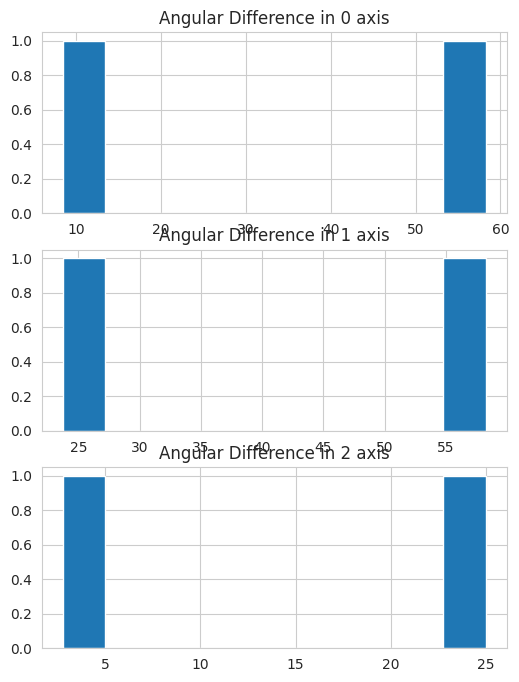

In [7]:
diffs_at_Reff = np.array(diffs_at_Reff)
#histogram of diffs_at_Reff
fig, ax = plt.subplots(3,1,figsize=(6,8))
for i in range(3):
    ax[i].hist(diffs_at_Reff[:,i],bins=10)
    ax[i].set_title(f'Angular Difference in {i} axis')
    #print count less than 10
    print(np.sum(diffs_at_Reff[:,i]<30))

In [ ]:
#test
def euler_to_rotation_matrix(phi, theta, psi):
    """ Converts Euler angles (in degrees) to a rotation matrix. """
    phi, theta, psi = np.deg2rad([phi, theta, psi])
    return R.from_euler('XYZ', [phi, theta, psi], degrees=False).as_matrix()

def generate_perturbed_orientations(base_orientations, num_samples=10, perturbation_range=1):
    """ Generate perturbed orientations around base orientations """
    np.random.seed(0)
    perturbed_orientations = []
    for base in base_orientations:
        for _ in range(num_samples):
            perturbed = base + np.random.uniform(-perturbation_range, perturbation_range, size=3)
            perturbed_orientations.append(perturbed)
    return np.array(perturbed_orientations)

# Base orientations with flips

xaxis_flip = R.from_matrix(np.array(([0,1,0],[-1,0,0],[0,0,1])))
print(xaxis_flip.as_euler('XYZ')*180/np.pi)




base_orientations = np.array([
    (180, 0, 0),
    (0, 0,0 ),
    #(180, 0, -180),
    (0, 0, 180)
])

# Generate perturbed orientations
perturbed_orientations = generate_perturbed_orientations(base_orientations, num_samples=25)

# Create rotation matrices for each perturbed orientation
rotation_matrices = np.array([euler_to_rotation_matrix(*ori) for ori in perturbed_orientations])

# Function to convert rotation matrices to Euler angles and adjust them
def rotation_matrices_to_euler(rot_matrices):
    euler_angles = np.array([R.from_matrix(matrix).as_euler('XYZ', degrees=True) for matrix in rot_matrices])
    return euler_angles

# Convert rotation matrices back to Euler angles
euler_angles = rotation_matrices_to_euler(rotation_matrices)


# Test plotting function
rbins = np.linspace(0, 1, len(perturbed_orientations))  # radius bins
plot_euler_angles(euler_angles,euler_angles, rbins, 'Simulation1', 'None', 1, 0.5)

In [70]:

I = np.identity(3)

print(np.linalg.det(I) , np.linalg.det(np.array(([0,1,0],[1,0,0],[0,0,1]))))


1.0 -1.0


In [ ]:


def plot_euler_angles(euler_Es, euler_Ed, rbins, sim, feedback, hid,Reff):
    fig, ax = plt.subplots(1,1,figsize=(6,2))
    ax.set_xlim([0,max(rbins)])
    
    Es_spline = None
    Ed_spline = None
    # Adjust the 0th Euler angles for symmetry about 90 degrees
    euler_Es[:, 0] = adjust_euler_angles(euler_Es[:, 0])
    euler_Ed[:, 0] = adjust_euler_angles(euler_Ed[:, 0])
    #plot raw data
    ax.plot(rbins, euler_Es[:, 0], label='Stellar: Phi', color='red')
    ax.plot(rbins, euler_Ed[:, 0], label='Dark Matter: Phi', color='black')

    spline_order = 3
    smoothing_factor = None

    Es_spline = scipy.interpolate.CubicSpline(rbins, euler_Es[:, 0], bc_type='natural')
    Ed_spline = scipy.interpolate.CubicSpline(rbins, euler_Ed[:, 0], bc_type='natural')
    
    #Es_spline = scipy.interpolate.UnivariateSpline(rbins, euler_Es[:,0])
    #Ed_spline = scipy.interpolate.UnivariateSpline(rbins, euler_Ed[:,0])
    sf = 500
    Es_spline.set_smoothing_factor(sf)
    Ed_spline.set_smoothing_factor(sf)

    #plot smoothed data

    evulate = np.linspace(np.min(rbins),np.max(rbins),100)
    ax.plot(evulate, Es_spline(evulate), color='red', ls = '--')
    ax.plot(evulate, Ed_spline(evulate), label='Smoothed', color='black',ls = '--')

    ax.axvline(Reff, color='black', alpha=0.5, label='R$_{eff}$')
    ax.grid(True)
    plt.xlabel('Radius Bins')
    plt.ylabel('Euler Angles (Phi)')
    plt.title(f'Euler Angles for Simulation: {sim}, Feedback: {feedback}, Halo ID: {hid}')
    plt.legend()
    plt.show()
def plot_euler_angles_on_sphere(euler_angles, rbins,sim,feedback,hid):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_wireframe(x, y, z, color="k",alpha = .1)

    # Convert Euler angles to unit vectors
    unit_vectors = R.from_euler('XYZ', euler_angles, degrees=True).apply([1, 0, 0])

    # Extract x, y, z coordinates
    x, y, z = unit_vectors[:, 0], unit_vectors[:, 1], unit_vectors[:, 2]

    # Scatter plot on the sphere using rbins for color
    scatter = ax.scatter(x, y, z, c=rbins, cmap='viridis', label='Euler Angles')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Euler Angles on a Sphere')

    # Colorbar
    cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
    cbar.set_label('Radial Bins')

    # Set equal scaling and limits to make it spherical
    ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

    plt.legend()
    plt.savefig(f'../../Figures/3DShapes/Orientations/{sim}.{feedback}.{hid}.png')
    #plt.close()

In [66]:
import numpy as np
from scipy.spatial.transform import Rotation
import pickle
import traceback
import pandas as pd

def calculate_orientation_angles(rotation_matrix1, rotation_matrix2):
    """
    Calculate the angles between two sets of principal axes defined by rotation matrices.
    
    Parameters:
    rotation_matrix1, rotation_matrix2: 3x3 numpy arrays representing rotation matrices
    
    Returns:
    dict: Contains absolute angle between orientations and angles between corresponding axes
    """
    # Extract the principal axes (columns of rotation matrices)
    axes1 = [rotation_matrix1[:, i] for i in range(3)]
    axes2 = [rotation_matrix2[:, i] for i in range(3)]
    
    # Calculate angles between corresponding axes
    # Note: We need to consider both positive and negative directions due to axial symmetry
    axis_angles = []
    for i in range(3):
        angle = np.arccos(np.clip(np.abs(np.dot(axes1[i], axes2[i])), -1.0, 1.0))
        angle_deg = np.degrees(angle)
        axis_angles.append(min(angle_deg, 180 - angle_deg))  # Consider symmetry
    
    # Calculate absolute angle between orientations
    # Using Frobenius norm of the difference between rotation matrices
    R_diff = np.dot(rotation_matrix1, rotation_matrix2.T)
    angle = np.arccos(np.clip((np.trace(R_diff) - 1) / 2, -1.0, 1.0))
    abs_angle_deg = np.degrees(angle)
    #abs_angle_deg should not be more than 90, if it is, then it is 180-abs_angle_deg
    if abs_angle_deg > 90:
        abs_angle_deg = 180 - abs_angle_deg
    
    
    return {
        'absolute_angle': abs_angle_deg,
        'axis_a_angle': axis_angles[0],  # x-axis alignment
        'axis_b_angle': axis_angles[1],  # y-axis alignment
        'axis_c_angle': axis_angles[2]   # z-axis alignment
    }

def get_orientation_angles(SimFilePath, feedback, reff_multi):
    diffs_at_Reff = []
    
    for i in range(len(SimFilePath)):
        SimInfo = pickle.load(open(SimFilePath[i], 'rb'))
        
        for sim in SimInfo:
            try:
                StShapes = pickle.load(open(f'../../Data/{sim}.{feedback[i]}.3DShapes.pickle', 'rb'))
                DMShapes = pickle.load(open(f'../../Data/{sim}.{feedback[i]}.DMShapes.pickle', 'rb'))
                Profiles = pickle.load(open(f'../../Data/{sim}.{feedback[i]}.Profiles.pickle', 'rb'))
            except:
                print(f'Error loading {sim} {feedback[i]}')
                continue
                
            for hid in SimInfo[sim]['goodhalos']:
                try:
                    rbins_s = StShapes[hid]['rbins']
                    rbins_d = DMShapes[hid]['rbins']
                    rotations_s = StShapes[hid]['rotations']
                    rotations_d = DMShapes[hid]['rotations']
                    Reff = Profiles[str(hid)]['x000y000']['Reff'] * reff_multi
                    
                    # Find the closest radius bin to Reff
                    idx_s = np.argmin(np.abs(rbins_s - Reff))
                    idx_d = np.argmin(np.abs(rbins_d - Reff))
                    #display warning if the difference is more than 0.5
                    threshold = 0.1
                    if np.abs(rbins_s[idx_s] - Reff) > threshold:
                        print(f'Warning: Stellar Reff mismatch for {sim}, Halo ID: {hid}')
                        print(np.abs(rbins_s[idx_s] - Reff))
                    if np.abs(rbins_d[idx_d] - Reff) > threshold:
                        print(f'Warning: Dark Matter Reff mismatch for {sim}, Halo ID: {hid}')
                        print(np.abs(rbins_d[idx_d] - Reff))
                    
                    # Get rotation matrices at Reff
                    rot_stars = rotations_s[idx_s]
                    rot_dm = rotations_d[idx_d]
                    
                    #print 3rd column of rot_stars and rot_dm
                    print(rot_stars[:,2])
                    print(rot_dm[:,2])
                    
                    
                    # Calculate orientation differences
                    angles = calculate_orientation_angles(rot_stars, rot_dm)
                    
                    # Store results with metadata
                    result = {
                        'simulation': sim,
                        'halo_id': hid,
                        'radius': rbins_s[idx_s],
                        **angles
                    }
                    diffs_at_Reff.append(result)
                    StShapes[hid]['diffs_at_Reff'] = result
                    
                except:
                    print(traceback.format_exc())
                    
            print('saving to pickle')
            
            #DMShapes[hid]['diffs_at_Reff'] = diffs_at_Reff
            pickle.dump(StShapes, open(f'../../Data/{sim}.{feedback[i]}.3DShapes.pickle', 'wb'))
            #pickle.dump(DMShapes, open(f'../../Data/{sim}.{feedback[i]}.DMShapes.pickle', 'wb'))

    return diffs_at_Reff

def plot_angle_distributions(diffs_at_Reff):
    """
    Plot histograms of the orientation angles between dark matter and stellar components
    
    Parameters:
    diffs_at_Reff: List of dictionaries containing angle measurements
    """
    # Convert list of dictionaries to arrays
    abs_angles = np.array([d['absolute_angle'] for d in diffs_at_Reff])
    axis_a_angles = np.array([d['axis_a_angle'] for d in diffs_at_Reff])
    axis_b_angles = np.array([d['axis_b_angle'] for d in diffs_at_Reff])
    axis_c_angles = np.array([d['axis_c_angle'] for d in diffs_at_Reff])
    
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Distribution of Alignment Angles between Dark Matter and Stellar Components', fontsize=14)
    
    # Common histogram parameters
    bins = np.arange(0, 91, 10)  # 10-degree bins from 0 to 90
    hist_kwargs = dict(
        bins=bins,
        density=True,
        alpha=0.7,
        color='blue',
        edgecolor='black'
    )
    
    # Plot absolute angles
    ax1.hist(abs_angles, **hist_kwargs)
    ax1.set_title('Absolute Orientation Angle')
    ax1.set_xlabel('Angle (degrees)')
    ax1.set_ylabel('Normalized Frequency')
    
    # Plot axis a angles
    ax2.hist(axis_a_angles, **hist_kwargs)
    ax2.set_title('Major Axis (a) Alignment')
    ax2.set_xlabel('Angle (degrees)')
    ax2.set_ylabel('Normalized Frequency')
    
    # Plot axis b angles
    ax3.hist(axis_b_angles, **hist_kwargs)
    ax3.set_title('Intermediate Axis (b) Alignment')
    ax3.set_xlabel('Angle (degrees)')
    ax3.set_ylabel('Normalized Frequency')
    
    # Plot axis c angles
    ax4.hist(axis_c_angles, **hist_kwargs)
    ax4.set_title('Minor Axis (c) Alignment')
    ax4.set_xlabel('Angle (degrees)')
    ax4.set_ylabel('Normalized Frequency')
    
    # Add summary statistics as text
    stats_text = (
        f'Number of halos: {len(diffs_at_Reff)}\n'
        f'Mean absolute angle: {np.nanmean(abs_angles):.1f}°\n'
        f'Mean axis angles:\n'
        f'  a: {np.nanmean(axis_a_angles):.1f}°\n'
        f'  b: {np.nanmean(axis_b_angles):.1f}°\n'
        f'  c: {np.nanmean(axis_c_angles):.1f}°'
    )
    fig.text(0.02, 0.98, stats_text, fontsize=10, va='top', ha='left')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    
    return fig




[ 0.64609527  0.75795794 -0.0897812 ]
[-0.65305483 -0.75472114  0.06257304]
[ 0.29450713  0.95479972 -0.04028708]
[-0.28166688 -0.95595003  0.08260325]
[0.34310317 0.52268164 0.78043841]
[-0.48654823 -0.62167347 -0.6138346 ]
[0.41474855 0.06378484 0.90769771]
[0.34088864 0.15399659 0.92740497]
[-0.03392711 -0.29172943  0.955899  ]
[ 0.1708724  -0.33711206  0.92582832]
[-0.08668011 -0.53422059  0.84088936]
[-0.0927773  -0.46595216  0.87993236]
[ 0.72708321 -0.53859683 -0.42575046]
[0.8824282  0.452972   0.12703087]
saving to pickle
[0.17622147 0.88082853 0.43941677]
[-0.16445455 -0.8847818  -0.43602278]
[ 0.08851479  0.02576169 -0.99574167]
[-0.02454777 -0.99954872  0.0173139 ]
[-0.56293375  0.55162449 -0.61548031]
[-0.61606418  0.47148767 -0.63100261]
[0.53486973 0.68664989 0.49236806]
[0.55607848 0.65539653 0.51110871]
[0.64332568 0.75372747 0.13426451]
[0.14604988 0.93960772 0.30952668]
[0.37584446 0.01311242 0.92658999]
[0.97987099 0.12175113 0.15820717]
[-0.59738406  0.78311402 -0.

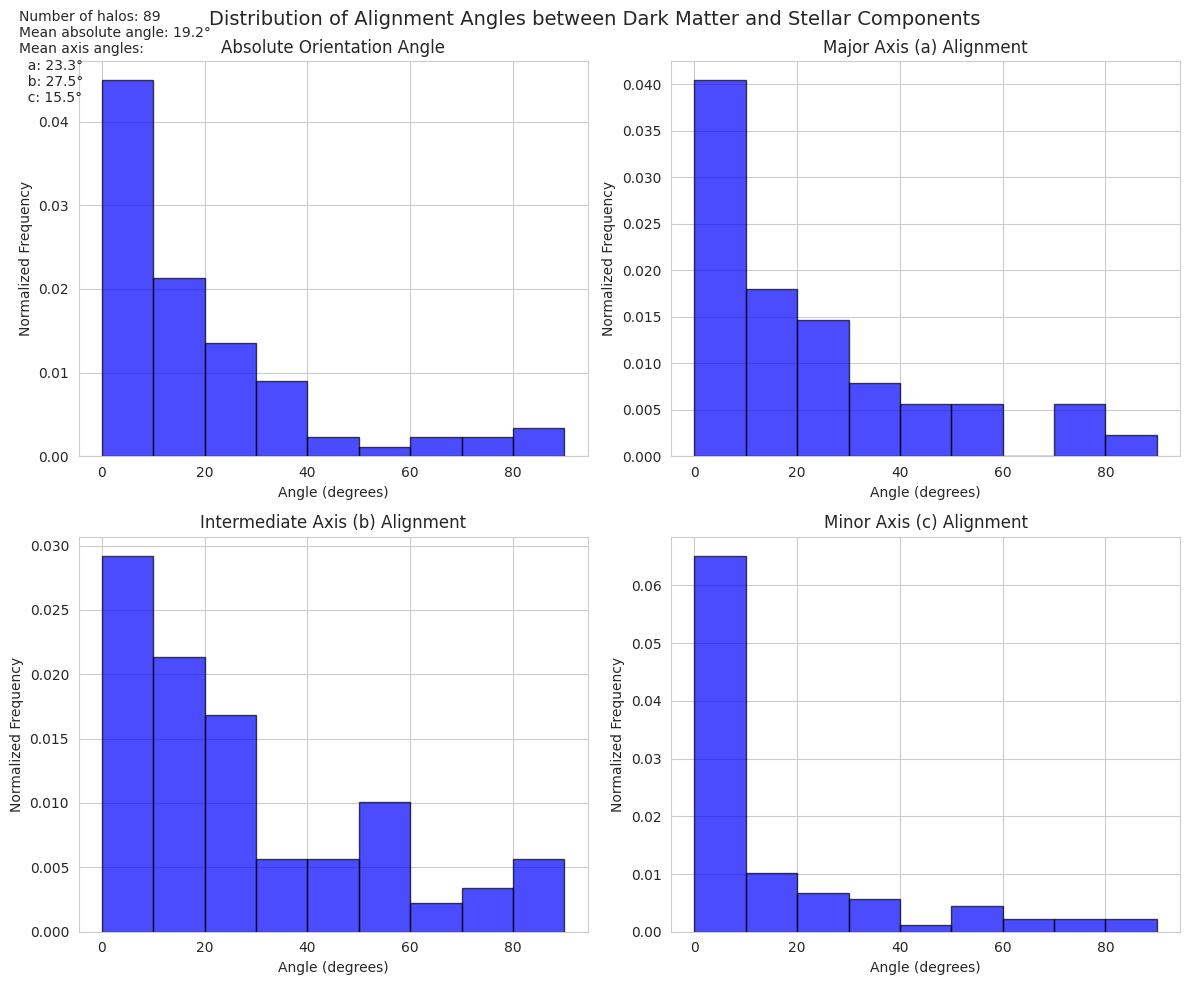

In [67]:


diffs_at_Reff = get_orientation_angles(SimFilePath, feedback, reff_multi*1)

fig = plot_angle_distributions(diffs_at_Reff)

saving to pickle
saving to pickle
saving to pickle
saving to pickle
0.1842091054422048
0.2353262500838058
saving to pickle
0.12646874185114365
0.14457717394464398
saving to pickle
saving to pickle
0.23536762371786368
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle
saving to pickle


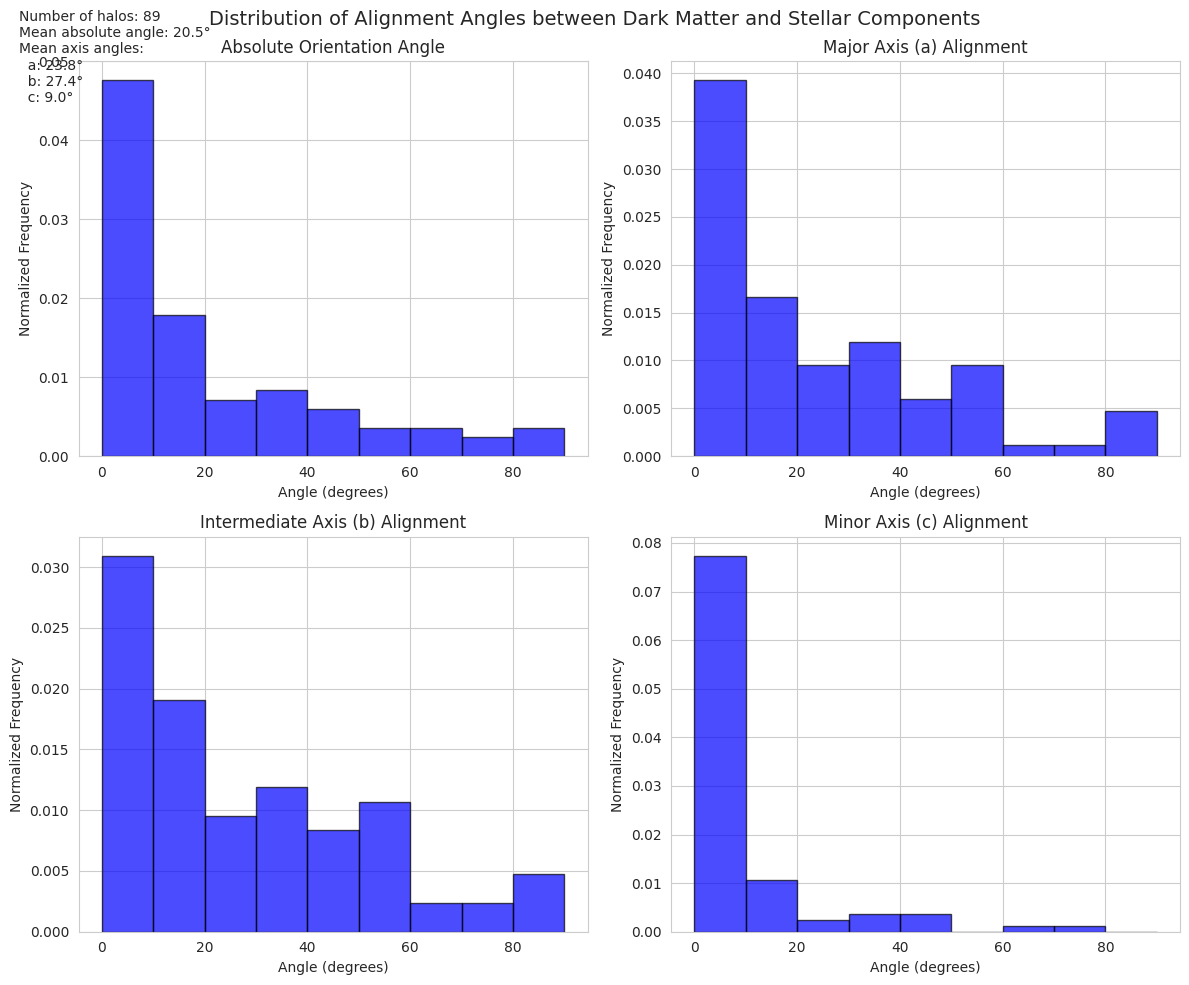

In [65]:

diffs_at_Reff = get_orientation_angles(SimFilePath, feedback, reff_multi*2)

fig = plot_angle_distributions(diffs_at_Reff)

In [29]:
print(diffs_at_Reff)

[{'simulation': 'cptmarvel', 'halo_id': 1, 'radius': 1.1921934264183585, 'absolute_angle': 13.605881303595092, 'axis_a_angle': 13.507361725405874, 'axis_b_angle': 13.544100226778202, 'axis_c_angle': 2.075694625617635}, {'simulation': 'cptmarvel', 'halo_id': 2, 'radius': 1.7999902263277663, 'absolute_angle': 11.691996405825474, 'axis_a_angle': 11.289312114733551, 'axis_b_angle': 11.690627875236157, 'axis_c_angle': 3.037469692005635}, {'simulation': 'cptmarvel', 'halo_id': 3, 'radius': 0.7981366009237243, 'absolute_angle': 149.63295015131493, 'axis_a_angle': 30.640041592293578, 'axis_b_angle': 30.573758360316504, 'axis_c_angle': 5.282996470617029}, {'simulation': 'cptmarvel', 'halo_id': 5, 'radius': 0.7291244278752737, 'absolute_angle': 27.69298117842176, 'axis_a_angle': 22.462529202241928, 'axis_b_angle': 23.035022514747673, 'axis_c_angle': 22.10349549954775}, {'simulation': 'cptmarvel', 'halo_id': 6, 'radius': 0.5468342222497418, 'absolute_angle': 14.935342423395026, 'axis_a_angle': 7.


Test: No rotation
Expected absolute angle: 0.0°
Calculated absolute angle: 0.0°
Axis angles: a=0.0°, b=0.0°, c=0.0°

Test: 180° rotation around x-axis
Expected absolute angle: 180.0°
Calculated absolute angle: 180.0°
Axis angles: a=0.0°, b=0.0°, c=0.0°

Test: 180° rotation around y-axis
Expected absolute angle: 180.0°
Calculated absolute angle: 180.0°
Axis angles: a=0.0°, b=0.0°, c=0.0°

Test: 180° rotation around z-axis
Expected absolute angle: 180.0°
Calculated absolute angle: 180.0°
Axis angles: a=0.0°, b=0.0°, c=0.0°

Test: 90° rotation around x-axis
Expected absolute angle: 90.0°
Calculated absolute angle: 90.0°
Axis angles: a=0.0°, b=90.0°, c=90.0°

Test: 90° rotation around y-axis
Expected absolute angle: 90.0°
Calculated absolute angle: 90.0°
Axis angles: a=90.0°, b=0.0°, c=90.0°

Test: 90° rotation around z-axis
Expected absolute angle: 90.0°
Calculated absolute angle: 90.0°
Axis angles: a=90.0°, b=90.0°, c=0.0°


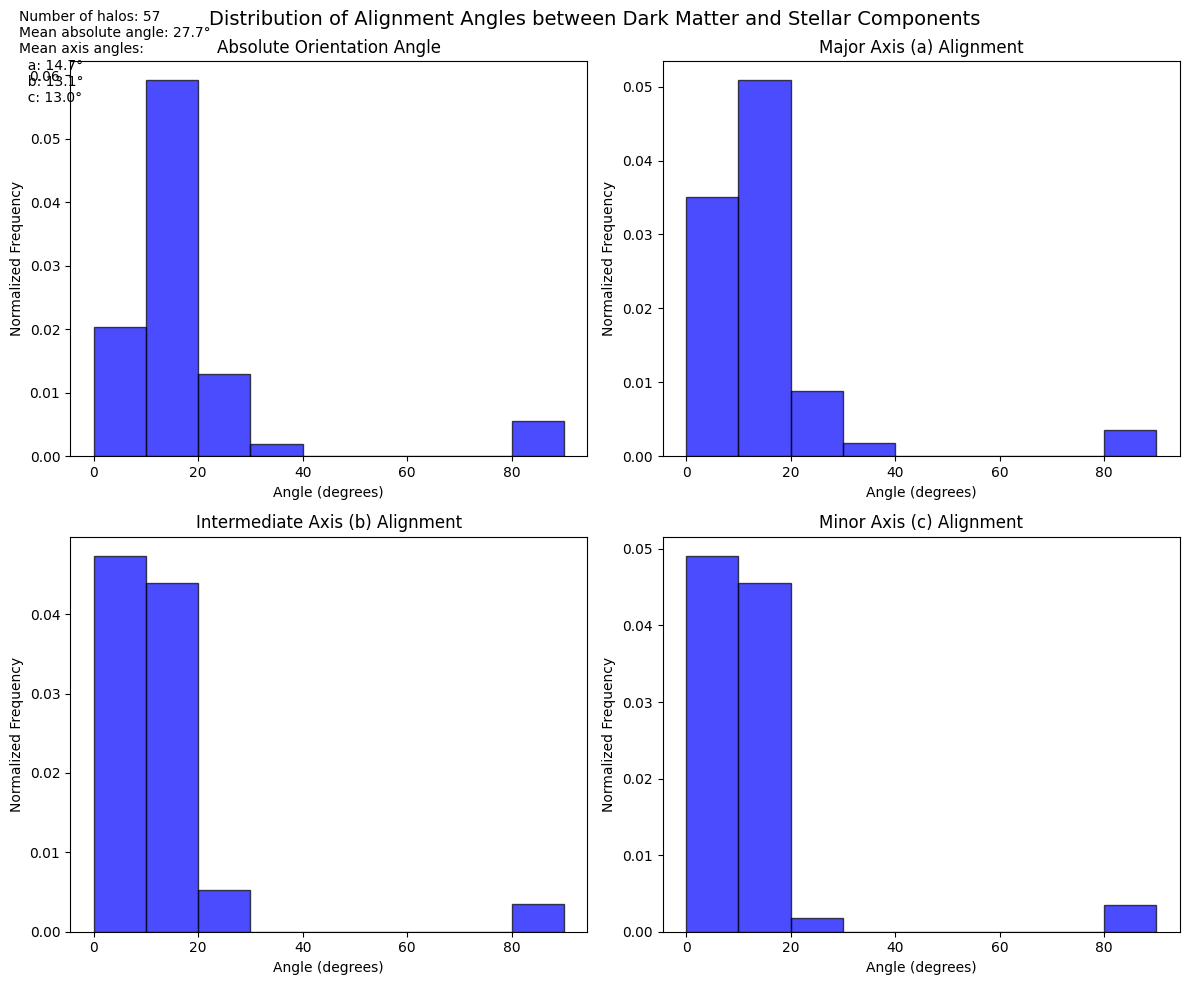


Summary of random rotation results:
Mean absolute angle: 15.3°
Std absolute angle: 5.7°


In [23]:
import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt

def create_test_rotations(n_random=50, seed=42):
    """
    Create test cases for rotation comparisons including:
    - Identity (no rotation)
    - 180° rotations around each axis
    - 90° rotations around each axis
    - Random rotations with controlled perturbations
    
    Returns:
    list of dictionaries containing test cases and expected results
    """
    np.random.seed(seed)
    test_cases = []
    
    # Identity matrix as reference
    base_matrix = np.eye(3)
    
    # Helper function to create rotation matrix
    def create_rotation_matrix(axis, angle_deg):
        angle_rad = np.radians(angle_deg)
        c, s = np.cos(angle_rad), np.sin(angle_rad)
        if axis == 'x':
            return np.array([[1, 0, 0], [0, c, -s], [0, s, c]])
        elif axis == 'y':
            return np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]])
        else:  # z
            return np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
    
    # Test Case 1: Identity (no rotation)
    test_cases.append({
        'name': 'No rotation',
        'matrix1': base_matrix,
        'matrix2': base_matrix,
        'expected_absolute': 0
    })
    
    # Test Case 2-4: 180° rotations around each axis
    for axis, axis_vector in zip(['x', 'y', 'z'], [[1,0,0], [0,1,0], [0,0,1]]):
        rot_matrix = create_rotation_matrix(axis, 180)
        test_cases.append({
            'name': f'180° rotation around {axis}-axis',
            'matrix1': base_matrix,
            'matrix2': rot_matrix,
            'expected_absolute': 180
        })
    
    # Test Case 5-7: 90° rotations around each axis
    for axis in ['x', 'y', 'z']:
        rot_matrix = create_rotation_matrix(axis, 90)
        test_cases.append({
            'name': f'90° rotation around {axis}-axis',
            'matrix1': base_matrix,
            'matrix2': rot_matrix,
            'expected_absolute': 90
        })
    
    # Random rotations with controlled perturbations
    for i in range(n_random):
        # Create random rotation angles with some noise
        angles = np.random.normal(0, 10, 3)  # mean=0, std=10 degrees
        rot = Rotation.from_euler('xyz', angles, degrees=True)
        rot_matrix = rot.as_matrix()
        
        test_cases.append({
            'name': f'Random rotation {i}',
            'matrix1': base_matrix,
            'matrix2': rot_matrix,
            'expected_absolute': np.linalg.norm(angles)  # approximate
        })
    
    return test_cases

def test_orientation_calculations():
    """
    Test the calculate_orientation_angles function with various rotation scenarios
    """
    test_cases = create_test_rotations()
    results = []
    
    for case in test_cases:
        angles = calculate_orientation_angles(case['matrix1'], case['matrix2'])
        results.append({
            'name': case['name'],
            'expected_absolute': case['expected_absolute'],
            **angles
        })
        
        # Print detailed results for specific test cases
        if 'Random' not in case['name']:
            print(f"\nTest: {case['name']}")
            print(f"Expected absolute angle: {case['expected_absolute']:.1f}°")
            print(f"Calculated absolute angle: {angles['absolute_angle']:.1f}°")
            print(f"Axis angles: a={angles['axis_a_angle']:.1f}°, "
                  f"b={angles['axis_b_angle']:.1f}°, "
                  f"c={angles['axis_c_angle']:.1f}°")
    
    return results

# Run tests and create visualization
test_results = test_orientation_calculations()

# Create histograms
fig = plot_angle_distributions(test_results)

# Add special markers for the specific test cases
def add_markers_to_histogram(ax, values, label):
    """Add vertical lines for specific test cases"""
    for val in values:
        if val > 0:  # Only mark non-zero values
            ax.axvline(x=val, color='red', linestyle='--', alpha=0.5)

# Get values for specific test cases
specific_cases = [case for case in test_results if 'Random' not in case['name']]
absolute_angles = [case['absolute_angle'] for case in specific_cases]

# Add markers to the absolute angle histogram (assumed to be the first subplot)
#add_markers_to_histogram(plt.gcf().axes[0], absolute_angles, 'Specific test cases')

plt.show()

# Print summary statistics
print("\nSummary of random rotation results:")
random_results = [case for case in test_results if 'Random' in case['name']]
abs_angles = [case['absolute_angle'] for case in random_results]
print(f"Mean absolute angle: {np.mean(abs_angles):.1f}°")
print(f"Std absolute angle: {np.std(abs_angles):.1f}°")

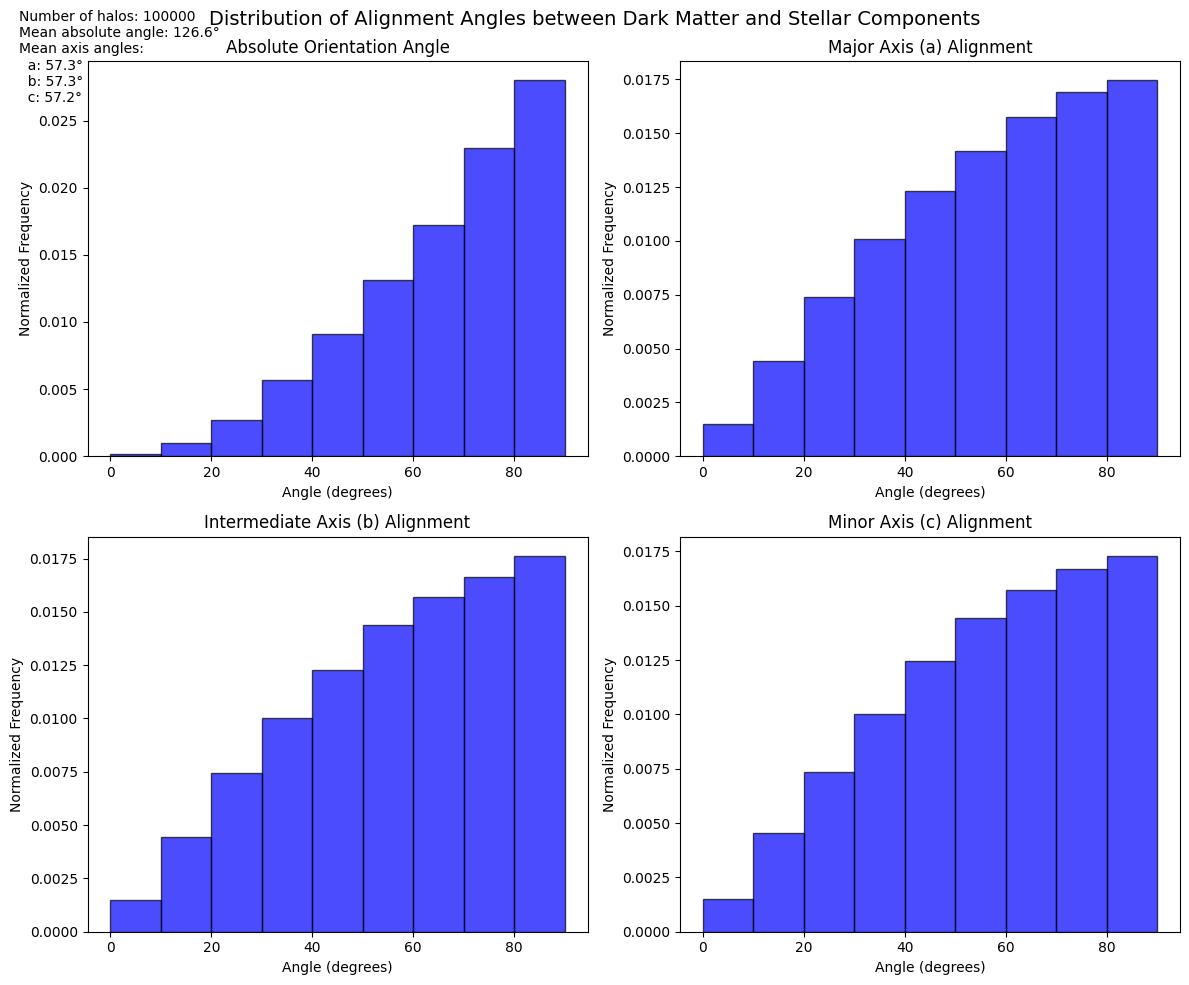


Summary Statistics:
Number of samples: 100000

Absolute angles:
Mean: 126.6°
Median: 132.5°
Std: 37.0°

Axis angles:
A - Mean: 57.3°, Median: 60.1°, Std: 21.5°
B - Mean: 57.3°, Median: 60.0°, Std: 21.6°
C - Mean: 57.2°, Median: 59.8°, Std: 21.5°

Correlations between axes:
    A     B     C
A: 1.000 0.246 0.239
B: 0.246 1.000 0.244
C: 0.239 0.244 1.000


In [26]:
import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt

def generate_uniform_rotations(n_samples=1000, seed=42):
    """
    Generate uniformly distributed random rotations in SO(3) space using quaternions.
    This method ensures proper uniform sampling in 3D rotation space.
    
    Parameters:
    n_samples: number of random rotations to generate
    seed: random seed for reproducibility
    
    Returns:
    list of dictionaries containing rotation matrices and their comparisons
    """
    np.random.seed(seed)
    
    def random_rotation_matrix():
        """Generate a random rotation matrix using quaternions"""
        # Generate random quaternion components
        x, y, z, w = np.random.normal(0, 1, 4)
        # Normalize to ensure it's a valid rotation
        norm = np.sqrt(x*x + y*y + z*z + w*w)
        q = np.array([x/norm, y/norm, z/norm, w/norm])
        return Rotation.from_quat(q).as_matrix()
    
    results = []
    base_matrix = np.eye(3)  # Reference orientation
    
    # Generate pairs of random rotations and calculate their relative orientations
    for i in range(n_samples):
        rot_matrix = random_rotation_matrix()
        angles = calculate_orientation_angles(base_matrix, rot_matrix)
        
        results.append({
            'name': f'Random rotation {i}',
            **angles
        })
    
    return results

# Generate random rotations and analyze them
n_samples = 10000
random_results = generate_uniform_rotations(n_samples)

# Create histograms
fig = plot_angle_distributions(random_results)

# Print summary statistics
abs_angles = [case['absolute_angle'] for case in random_results]
axis_a_angles = [case['axis_a_angle'] for case in random_results]
axis_b_angles = [case['axis_b_angle'] for case in random_results]
axis_c_angles = [case['axis_c_angle'] for case in random_results]

print("\nSummary Statistics:")
print(f"Number of samples: {n_samples}")
print("\nAbsolute angles:")
print(f"Mean: {np.mean(abs_angles):.1f}°")
print(f"Median: {np.median(abs_angles):.1f}°")
print(f"Std: {np.std(abs_angles):.1f}°")

print("\nAxis angles:")
print(f"A - Mean: {np.mean(axis_a_angles):.1f}°, Median: {np.median(axis_a_angles):.1f}°, Std: {np.std(axis_a_angles):.1f}°")
print(f"B - Mean: {np.mean(axis_b_angles):.1f}°, Median: {np.median(axis_b_angles):.1f}°, Std: {np.std(axis_b_angles):.1f}°")
print(f"C - Mean: {np.mean(axis_c_angles):.1f}°, Median: {np.median(axis_c_angles):.1f}°, Std: {np.std(axis_c_angles):.1f}°")

# Additional check: Calculate correlations between axes
correlations = np.corrcoef([axis_a_angles, axis_b_angles, axis_c_angles])
print("\nCorrelations between axes:")
print("    A     B     C")
print(f"A: {correlations[0,0]:.3f} {correlations[0,1]:.3f} {correlations[0,2]:.3f}")
print(f"B: {correlations[1,0]:.3f} {correlations[1,1]:.3f} {correlations[1,2]:.3f}")
print(f"C: {correlations[2,0]:.3f} {correlations[2,1]:.3f} {correlations[2,2]:.3f}")

# Optional: Add theoretical expectations for uniform distribution
def add_theoretical_distribution(ax):
    """Add theoretical distribution curve for uniform random rotations"""
    x = np.linspace(0, 90, 100)
    # Theoretical distribution for random 3D rotations (simplified)
    y = np.sin(np.radians(x)) / 90
    ax.plot(x, y, 'r--', label='Theoretical', alpha=0.7)
    ax.legend()

# Add theoretical curves to each subplot
for ax in fig.axes:
    add_theoretical_distribution(ax)

plt.show()